In [ ]:
import sys
sys.path.append('/Users/kenzatazi/Documents/CDT/Code')

from load import beas_sutlej_gauges, era5, data_dir
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import GPy
import scipy as sp
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
#from utils.metrics import msll
import xarray as xr

In [ ]:
import emukit
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

In [ ]:
# Load data
minyear = 2000
maxyear = 2001

In [ ]:
all_station_dict = pd.read_csv( data_dir + 'bs_gauges/gauge_info.csv', index_col='station').T

In [ ]:
station_list = list(all_station_dict)

In [ ]:
hf_train_list = []
for station in station_list:
    station_ds = beas_sutlej_gauges.gauge_download(
        station, minyear=minyear, maxyear=maxyear)
    hf_train_list.append(station_ds.to_dataframe().dropna().reset_index())
hf_train_df = pd.concat(hf_train_list)

In [ ]:
# era5.collect_ERA5('indus', minyear=minyear, maxyear=maxyear)
era5_ds = era5.collect_ERA5('indus', minyear=minyear, maxyear=maxyear)
era5_df = era5_ds.to_dataframe()

lf_df = era5_df.dropna().reset_index()
lf_df1 = lf_df[lf_df['lat'] <= 33.5]
lf_df2 = lf_df1[lf_df1['lat'] >= 30]
lf_df3 = lf_df2[lf_df2['lon'] >= 75.5]
lf_train_df = lf_df3[lf_df3['lon'] <= 83]

In [ ]:
hf_train_df

In [ ]:
# Import SRTM data
era5_ds = era5.collect_ERA5('beas_sutlej', minyear, maxyear)
srtm_ds = xr.open_dataset('/Users/kenzatazi/Documents/CDT/Code/data/Elevation/SRTM_data.nc')
srtm_ds = srtm_ds.rename({'nlat': 'lat', 'nlon': 'lon'})

In [ ]:
# Mask to beas and sutlej
mask_filepath = '/Users/kenzatazi/Documents/CDT/Code/data/Masks/Beas_Sutlej_highres_mask.nc'
mask = xr.open_dataset(mask_filepath)
mask_da = mask.Overlap
msk_srtm_ds = srtm_ds.where(mask_da > 0, drop=True)

In [ ]:
rg_era5_ds = era5_ds.interp_like(msk_srtm_ds, method='linear')
rg_srtm_ds = srtm_ds.interp_like(msk_srtm_ds, method='linear')

In [ ]:
hr_data_ds = xr.merge([rg_era5_ds.tp, msk_srtm_ds.elevation])

In [ ]:
hr_data_ds.elevation.plot()

In [ ]:
hr_data_df = hr_data_ds.to_dataframe().dropna().reset_index()

In [ ]:
hr_data_df

In [ ]:
# Prepare data

# Transformations
lf_train_df['tp_tr'], lf_lambda = sp.stats.boxcox(
    lf_train_df['tp'].values + 0.01)
hf_train_df['tp_tr'] = sp.stats.boxcox(
    hf_train_df['tp'].values + 0.01, lmbda=lf_lambda)

# Splitting
x_train_lf = lf_train_df[['time', 'lat', 'lon', 'z']].values.reshape(-1, 4)
y_train_lf = lf_train_df['tp_tr'].values.reshape(-1, 1)
x_train_hf = hf_train_df[['time', 'lat', 'lon', 'z']].values.reshape(-1, 4)
y_train_hf = hf_train_df[['tp_tr']].values.reshape(-1, 1)
x_val = hr_data_df[['time', 'lat', 'lon', 'elevation']].values.reshape(-1, 4)


# Scaling
scaler = StandardScaler().fit(x_train_hf)
x_train_hf1 = scaler.transform(x_train_hf)
x_train_lf1 = scaler.transform(x_train_lf)
x_val1 = scaler.transform(x_val)

# Input data
X_train, Y_train = convert_xy_lists_to_arrays([x_train_lf1[:], x_train_hf1[:]], [y_train_lf[:], y_train_hf[:]])

# Train and evaluate
kern1 = GPy.kern.RBF(input_dim=4, ARD=True)
kernels = [kern1, GPy.kern.RBF(input_dim=4, ARD=True)]
lin_mf_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)
gpy_lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, n_fidelities=2,)
gpy_lin_mf_model.mixed_noise.Gaussian_noise.fix(0)
gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0)
lin_mf_model = GPyMultiOutputWrapper(gpy_lin_mf_model, 2, n_optimization_restarts=5)
lin_mf_model.optimize()

# ALL
n = x_val.shape[0]
x_met = convert_x_list_to_array([x_val1, x_val1])
y_pred0, y_var0 = lin_mf_model.predict(x_met[n:])
y_pred_low, y_var_low = lin_mf_model.predict(x_met[:n])

In [ ]:
# ALL
y_pred = sp.special.inv_boxcox(y_pred0, lf_lambda).reshape(-1)

In [ ]:
hr_data_df['pred'] = y_pred

In [ ]:
hr_data_df['pred'].hist(bins=30)

In [ ]:
hr_data_df['tp'].hist(bins=30)

<AxesSubplot: >

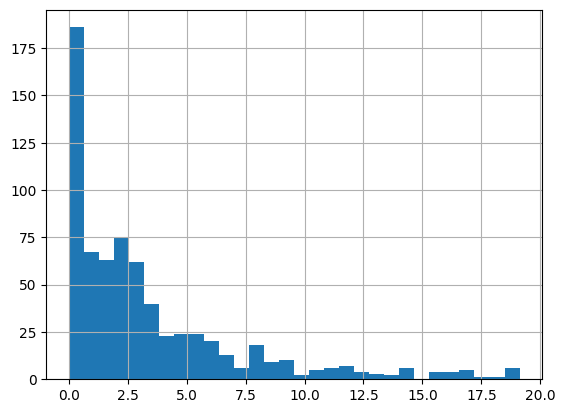

In [16]:
lf_train_df['tp'].hist(bins=30)

<AxesSubplot: xlabel='lon', ylabel='lat'>

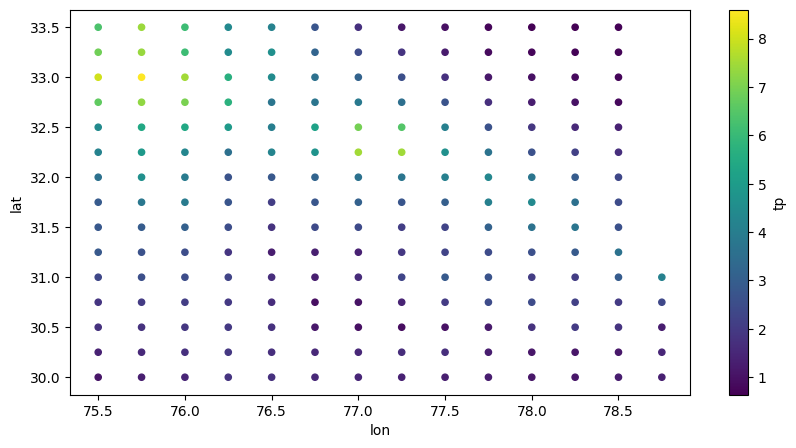

In [22]:
lf_train_df[:200].plot.scatter(x='lon', y='lat', c='tp',figsize=(10,5))

<AxesSubplot: xlabel='lon', ylabel='lat'>

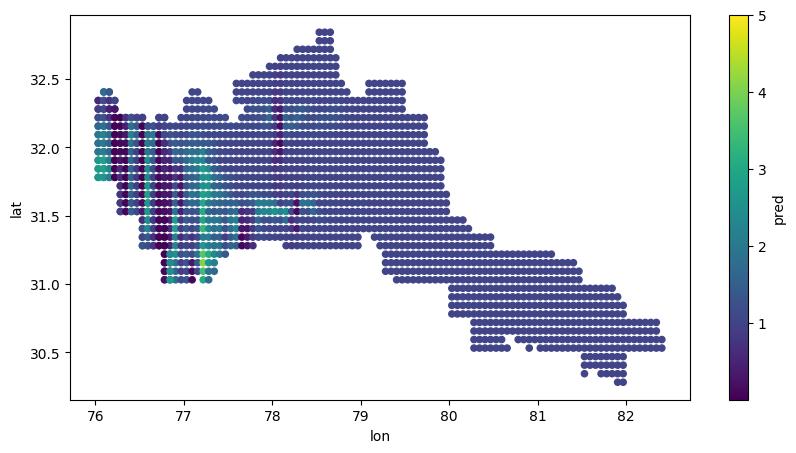

In [130]:
hr_data_df[:1785].plot.scatter(x='lon', y='lat', c='pred', vmax=5, figsize=(10,5))

In [116]:
x_val = hr_data_df[['time', 'lat', 'lon', 'elevation']].values.reshape(-1, 4)
x_val1 = scaler.transform(x_val)

In [117]:
# ALL
n = x_val.shape[0]
x_met = convert_x_list_to_array([x_val1, x_val1])
y_pred0, y_var0 = lin_mf_model.predict(x_met[n:])
y_pred_low, y_var_low = lin_mf_model.predict(x_met[:n])

In [118]:
y_pred0.shape

(19308, 1)

In [119]:
y_pred = sp.special.inv_boxcox(y_pred0, lf_lambda).reshape(-1)

In [120]:
hr_data_df['pred'] = y_pred